In [ ]:
# python setup.py sdist bdist_wheel
# pip install -e .

In [6]:
import warnings
from statsbombpy.api_client import NoAuthWarning
warnings.simplefilter('ignore', NoAuthWarning)
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl

api = StatsBombLoader(getter="remote", creds={"user": "", "passwd": ""})

g = 18240
team_id = 169
df_teams = api.teams(game_id=g)
df_players = api.players(game_id=g)
df_events = api.events(game_id=g)

df_actions = spadl.statsbomb.convert_to_actions(df_events, home_team_id=team_id)
df_actions = (
spadl
.add_names(df_actions)
.merge(api.teams(game_id=g))
.merge(api.players(game_id=g))
)
df_actions = df_actions.sort_values(by=['period_id', 'time_seconds'], ascending=[True, True]).reset_index(drop=True)

In [7]:
df_actions.columns

Index(['game_id', 'original_event_id', 'period_id', 'time_seconds', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_id',
       'result_id', 'bodypart_id', 'action_id', 'type_name', 'result_name',
       'bodypart_name', 'team_name', 'player_name', 'nickname',
       'jersey_number', 'is_starter', 'starting_position_id',
       'starting_position_name', 'minutes_played'],
      dtype='object')

In [8]:
df_actions['type_name'].unique()

array(['pass', 'dribble', 'throw_in', 'tackle', 'foul', 'freekick_short',
       'take_on', 'bad_touch', 'cross', 'shot', 'corner_crossed',
       'clearance', 'goalkick', 'keeper_claim', 'interception',
       'keeper_save', 'freekick_crossed', 'shot_penalty', 'keeper_punch'],
      dtype=object)

10


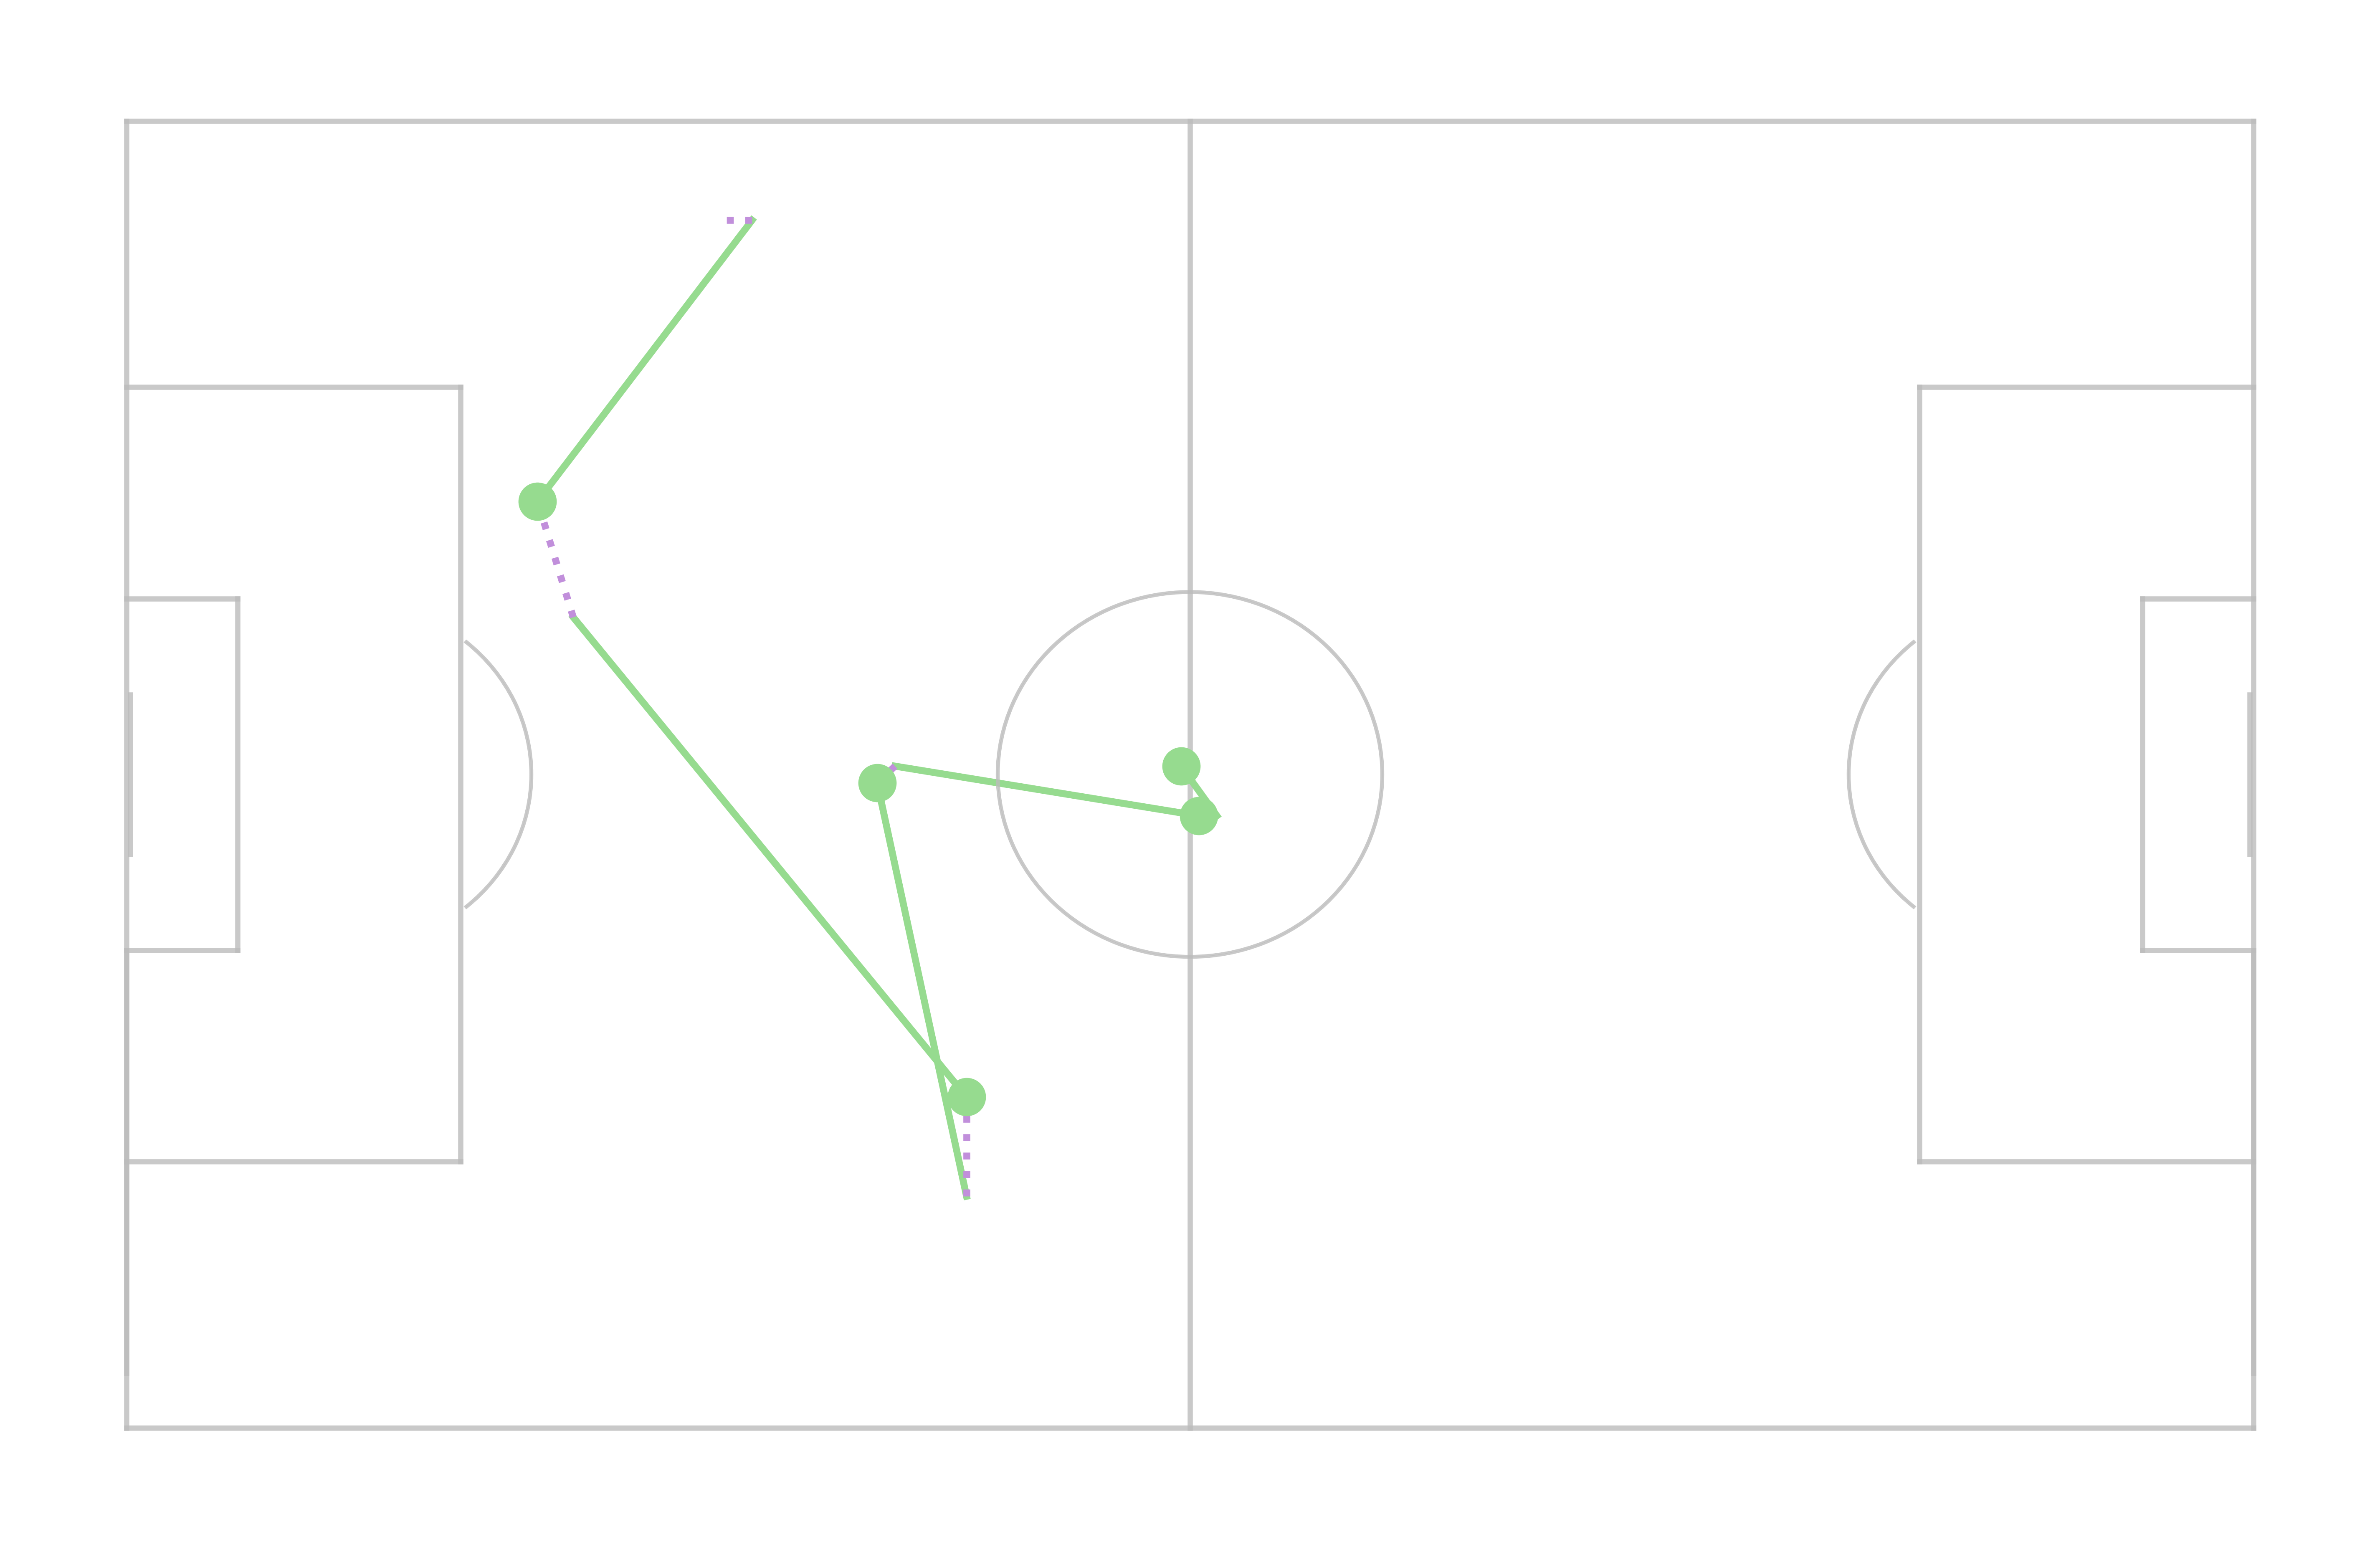

In [9]:
import statsbombplot as pys

df = df_actions[0:10].copy()
print(len(df))
ax = pys.draw_pitch()
pys.draw_actions(ax, df)

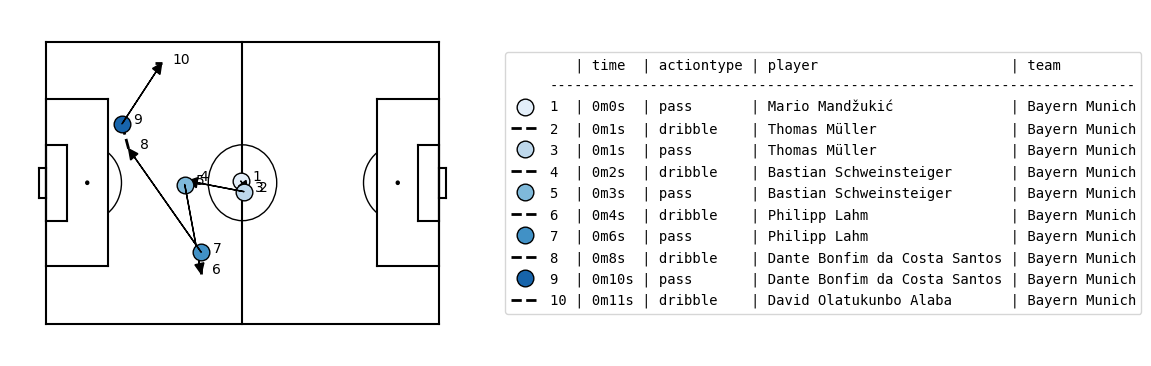

In [10]:
import matplotsoccer

def nice_time(row):
    minute = int((row.period_id-1)*45 +row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"

df["nice_time"] = df.apply(nice_time, axis=1)
labels = df[["nice_time", "type_name", "player_name", "team_name"]]

ax = matplotsoccer.actions(
        location=df[["start_x", "start_y", "end_x", "end_y"]],
        action_type=df.type_name,
        team= df.team_name,
        result= df.result_name == "success",
        label=labels,
        labeltitle=["time", "actiontype", "player", "team"],
        zoom=False,
        figsize=6
    )